In [1]:
!pip install fastFM

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Upload kaggle.json and run this if you run the notebook on colab

In [2]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: Permission denied
cp: failed to access '/root/.kaggle': Permission denied


In [3]:
import os
import numpy as np
import shutil
import seaborn as sns
import scipy

import pandas as pd

from livelossplot import PlotLosses
import matplotlib.pyplot as plt

import sklearn
import sklearn.compose
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

import fastFM.als
import fastFM.sgd
import fastFM.mcmc


import tqdm

from kaggle.api.kaggle_api_extended import KaggleApi
from kaggle.api_client import ApiClient

In [4]:
plt.style.use('dark_background')

In [5]:
def preprocess_game_info_df(game_info_df):
  game_info_df['Genre'] = game_info_df['Genre'].str.replace(' ', '-').str.replace(';', ' ')
  # game_info_df = game_info_df[game_info_df['Platform'] == 'PC']
  game_info_df['Metascore'][game_info_df['Metascore'] == 'not specified'] = 'nan'
  game_info_df['Metascore'] = game_info_df['Metascore'].astype('float') / 100
  game_info_df['Metascore'] = game_info_df['Metascore'].fillna(game_info_df['Metascore'].mean(skipna=True))
  game_info_df['Avg_Userscore'][game_info_df['Avg_Userscore'] == 'tbd'] = 8
  game_info_df['Avg_Userscore'][game_info_df['Avg_Userscore'] == 'not specified'] = 'nan'
  game_info_df['Avg_Userscore'] = game_info_df['Avg_Userscore'].astype('float') / 10
  game_info_df['Avg_Userscore'] = game_info_df['Avg_Userscore'].fillna(game_info_df['Avg_Userscore'].mean(skipna=True))
  return game_info_df


def preprocess_game_comments_df(game_comments_df):
  game_comments_df = pd.read_csv('metacritic_game_user_comments.csv', index_col=0)
  # game_comments_df = game_comments_df[game_comments_df['Platform'] == 'PC']
  return game_comments_df[~game_comments_df['Username'].isna()]

In [6]:
def get_column_inverse_norms(X, tol=1e-5):
    features_matrix_maxes = X.max(axis=0).toarray()
    features_matrix_maxes[np.abs(features_matrix_maxes) < tol] = 1
    return scipy.sparse.spdiags(1.0 / features_matrix_maxes, 0, features_matrix_maxes.shape[1], features_matrix_maxes.shape[1])


def column_normalize_csr_matrix(X, inverse_norms):
    return scipy.sparse.csr_matrix(X @ inverse_norms)

In [7]:
def add_label_encoded_column(df, colname, col_le=None):
  if col_le is None:
    col_le = LabelEncoder().fit(df[colname])
  df[colname + '_label_ID'] = col_le.transform(df[colname])
  return df, col_le


def get_rating_matrix(df, n_items):
  n_users = df['Username_label_ID'].max() + 1
  return scipy.sparse.csr_matrix((df['Userscore'], (df['Username_label_ID'], df['Title_label_ID'])), shape=(n_users, n_items))

In [8]:
def map_dict(rating_dict, username='me'):
  title_ids = title_le.transform(list(rating_dict.keys()))
  raw_df = pd.DataFrame.from_records([{'Username': username, 'Title': title, 'Title_label_ID': title_id, 'Userscore': score} for (title_id, (title, score)) in zip(title_ids, rating_dict.items())])
  return raw_df


def get_ratings_matrix_from_ratings_dict(ratings_df, comments_df, title_le):
  ratings_df['Username_label_ID'] = 0
  return get_rating_matrix(ratings_df, comments_df['Title_label_ID'].max() + 1)

### Genre features for users



In [9]:
def make_user_game_vectorizer(primary_columns=['Title_label_ID', 'Username_label_ID', 'Platform'], selected_columns=['Metascore', 'Avg_Userscore'], bow_columns=['Genre']):
    column_encoders = [(col, OneHotEncoder(categories='auto'), [col]) for col in primary_columns]
    column_selectors = [(col, StandardScaler(), [col]) for col in selected_columns]
    bow_column_encoders = [(col, CountVectorizer(binary=True), col) for col in bow_columns]
    return sklearn.compose.ColumnTransformer(column_encoders + column_selectors + bow_column_encoders)

In [10]:
default_fm_hyperparams = dict(init_stdev=0.01, rank=50, l2_reg_w=5.0, l2_reg_V=8.0)


def setup_fm(fm_hyperparams):
    return fastFM.als.FMRegression(n_iter=1, **fm_hyperparams)


def train_fm(
        X_train,
        y_train,
        X_test,
        y_test,
        n_iter=25,
        step_size=1,
        fm_hyperparams=default_fm_hyperparams,
        early_stopping=True):
    fm = setup_fm(default_fm_hyperparams)
    fm.fit(X_train, y_train)
    
    liveplot = PlotLosses()

    for i in tqdm.tqdm(range(1, n_iter)):
        fm.fit(X_train, y_train, n_more_iter=1)
        y_pred = fm.predict(X_test)

        liveplot.update({
            'rmse': np.sqrt(mean_squared_error(fm.predict(X_train), y_train)),
            'val_rmse': np.sqrt(mean_squared_error(fm.predict(X_test), y_test)),
            'mae': mean_absolute_error(fm.predict(X_train), y_train),
            'val_mae': mean_absolute_error(fm.predict(X_test), y_test)
        })
        liveplot.draw()
        
    return fm


def did_error_improve(errors, steps):
    if len(errors) <= steps:
        return True
    else:
        return min(errors[:-steps]) >= min(errors[-steps:])


def train_mcmc_fm(
        X_train_val,
        y_train_val,
        val_size=0.1,
        n_iter=25,
        step_size=1,
        init_stdev=0.1,
        rank=50,
        early_stopping=True,
        early_stopping_patience=5):
    fm = fastFM.mcmc.FMRegression(n_iter=1, rank=rank, init_stdev=init_stdev)
    
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=0)
    fm.fit_predict(X_train, y_train, X_val)
    
    liveplot = PlotLosses()
    plt.style.use('dark_background')

    tqdm_iter = tqdm.tqdm(range(1, n_iter))
    for i in tqdm_iter:
        y_pred = fm.fit_predict(X_train, y_train, X_val, n_more_iter=1)

        current_val_metric = np.sqrt(mean_squared_error(fm.predict(X_val), y_val))
        liveplot.update({
            'rmse': np.sqrt(mean_squared_error(fm.predict(X_train), y_train)),
            'val_rmse': current_val_metric,
            'mae': mean_absolute_error(fm.predict(X_train), y_train),
            'val_mae': mean_absolute_error(fm.predict(X_val), y_val)
        })
        liveplot.draw()
        checked_steps = [item['val_rmse'] for item in liveplot.logs]
        if not did_error_improve(checked_steps, early_stopping_patience):
            tqdm_iter.close()
            break
        
    return fm, liveplot

In [11]:
fm = fastFM.mcmc.FMRegression(n_iter=1, rank=10, init_stdev=0.1)

In [12]:
api = KaggleApi(ApiClient())
api.authenticate()
if not os.path.exists('metacritic-video-game-comments.zip'):
    api.dataset_download_files(dataset='dahlia25/metacritic-video-game-comments', unzip=True)

In [13]:
!head metacritic_game_info.csv

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
1,Tony Hawk's Pro Skater 2,2000,NeversoftEntertainment,Sports;Alternative;Skateboarding,PlayStation,98,7.4,1-2 
2,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,PlayStation3,98,7.5,1 Player
3,SoulCalibur,1999,Namco,Action;Fighting;3D,Dreamcast,98,8.6,1-2 
4,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,Xbox360,98,7.9,1 Player
5,Super Mario Galaxy,2007,Nintendo,Action;Platformer;Platformer;3D;3D,Wii,97,9.0,No Online Multiplayer
6,Super Mario Galaxy 2,2010,NintendoEADTokyo,Action;Platformer;Platformer;3D;3D,Wii,97,9.1,No Online Multiplayer
7,Grand Theft Auto V,2014,RockstarNorth,Action Adventure;Modern;Open-World,XboxOne,97,7.8,Up to 30 
8,Grand Theft Auto V,2013,RockstarNorth,Modern;Action Adventure;Modern;Open-World,PlayStation3,97,8.3,Up to 16

In [14]:
game_comments_df = pd.read_csv('metacritic_game_user_comments.csv', index_col=0)
game_comments_df = preprocess_game_comments_df(game_comments_df)

In [15]:
game_info_df = pd.read_csv('metacritic_game_info.csv', index_col=0)
game_info_df = preprocess_game_info_df(game_info_df)
game_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 8 columns):
Title            5000 non-null object
Year             5000 non-null object
Publisher        5000 non-null object
Genre            5000 non-null object
Platform         5000 non-null object
Metascore        5000 non-null float64
Avg_Userscore    5000 non-null float64
No_Players       4993 non-null object
dtypes: float64(2), object(6)
memory usage: 351.6+ KB


/home/kuba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/kuba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
users_index = game_comments_df['Username'].unique()
titles_index = game_info_df['Title'].values

from sklearn.preprocessing import LabelEncoder
users_le = LabelEncoder().fit(users_index)
titles_le = LabelEncoder().fit(titles_index)

In [17]:
game_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283980 entries, 0 to 283982
Data columns (total 5 columns):
Title        283980 non-null object
Platform     283980 non-null object
Userscore    283980 non-null int64
Comment      283957 non-null object
Username     283980 non-null object
dtypes: int64(1), object(4)
memory usage: 13.0+ MB


In [18]:
game_comments_df.describe()

,Userscore
count,283980.000000
mean,7.618329
std,3.131772
min,0.000000
25%,7.000000
50%,9.000000
75%,10.000000
max,10.000000


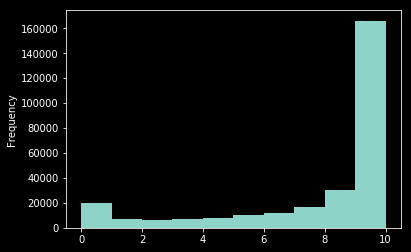

In [19]:
game_comments_df['Userscore'].plot.hist();

## Restrict titles to these that have reviews

In [20]:
def get_column_values_with_min_occurrences(df, col, min_occurrences=5):
    col_value_counts = df[col].value_counts()
    return col_value_counts[col_value_counts >= min_occurrences].index

In [21]:
user_comment_counts = game_comments_df['Username'].value_counts()
title_counts = game_comments_df['Title'].value_counts()

more_than_one_comment_game_comments_df = game_comments_df[
    game_comments_df['Title'].isin(get_column_values_with_min_occurrences(game_comments_df, 'Title')) &
    game_comments_df['Username'].isin(get_column_values_with_min_occurrences(game_comments_df, 'Username'))
]

In [22]:
more_than_one_comment_game_comments_df.shape

(113670, 5)

In [23]:
game_info_df = game_info_df[game_info_df['Title'].isin(more_than_one_comment_game_comments_df['Title'])]
game_info_df, title_le = add_label_encoded_column(game_info_df, 'Title')

game_info_df = game_info_df.sort_values(by='Title_label_ID')

In [24]:
used_comments_df, username_le = add_label_encoded_column(more_than_one_comment_game_comments_df, 'Username')
used_comments_df, title_le = add_label_encoded_column(used_comments_df, 'Title', title_le)

/home/kuba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [25]:
used_comments_df = used_comments_df.merge(game_info_df[['Title', 'Avg_Userscore', 'Metascore', 'Publisher', 'Platform', 'Genre']], on=['Title', 'Platform'])

In [26]:
used_comments_df.columns

Index(['Title', 'Platform', 'Userscore', 'Comment', 'Username',
       'Username_label_ID', 'Title_label_ID', 'Avg_Userscore', 'Metascore',
       'Publisher', 'Genre'],
      dtype='object')

In [27]:
#used_comments_df['Userscore'] = used_comments_df['Userscore'] - used_comments_df['Userscore'].median()

In [28]:
vectorizer = make_user_game_vectorizer()

In [29]:
X = vectorizer.fit_transform(used_comments_df)

In [30]:
X.shape

(113868, 12509)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, used_comments_df['Userscore'], test_size=0.1, random_state=0)

## Machine learning for predicting Userscore


### SGD Linear Regression

In [32]:
from sklearn.linear_model import SGDRegressor

lin_reg = SGDRegressor(alpha=1, l1_ratio=0.5, random_state=0)

In [33]:
%%time
lin_reg.fit(X_train, y_train)

CPU times: user 1.68 s, sys: 120 ms, total: 1.8 s
Wall time: 1.59 s


SGDRegressor(alpha=1, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.5,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=0,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [34]:
y_pred_lin_reg = lin_reg.predict(X_test)

In [35]:
np.sqrt(mean_squared_error(y_pred_lin_reg , y_test))

2.3737659586240536

### Factorization Machines

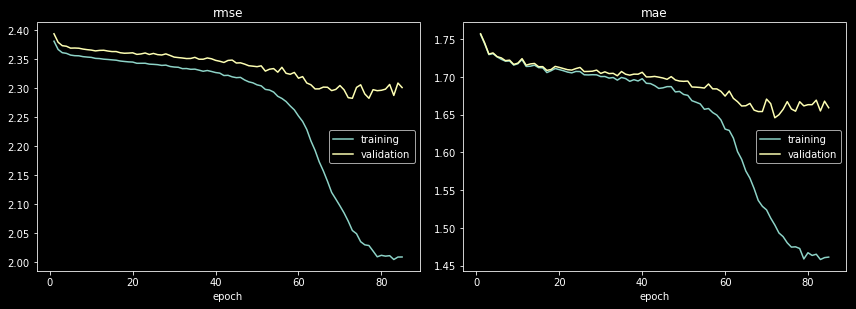

rmse:
training   (min:    2.005, max:    2.381, cur:    2.009)
validation (min:    2.282, max:    2.394, cur:    2.301)

mae:
training   (min:    1.458, max:    1.756, cur:    1.461)
validation (min:    1.646, max:    1.757, cur:    1.659)
CPU times: user 2min 49s, sys: 40 s, total: 3min 29s
Wall time: 2min 13s


In [36]:
%%time
fm, liveplot = train_mcmc_fm(X_train, y_train, n_iter=500, rank=10, init_stdev=1e-3, early_stopping_patience=8)

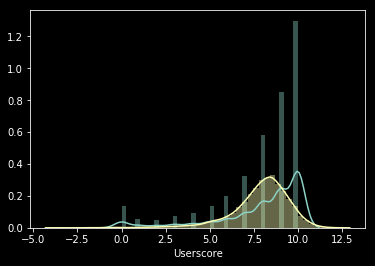

In [37]:
y_pred = fm.predict(X_test)

sns.distplot(y_test);
sns.distplot(y_pred);

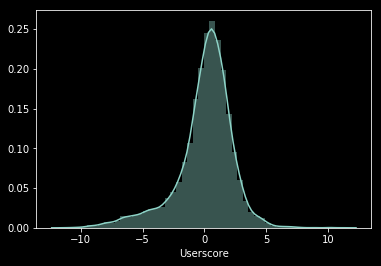

In [38]:
sns.distplot(y_test - y_pred);

In [39]:
np.sqrt(mean_squared_error(fm.predict(X_test) , y_test))

2.280464703668659

## Preparing data for recommendations

In [40]:
matrix_data = (used_comments_df['Userscore'], (used_comments_df['Username_label_ID'], used_comments_df['Title_label_ID']))
n_rows = matrix_data[1][0].max() + 1
n_cols = matrix_data[1][1].max() + 1
n_rows, n_cols

(10233, 2081)

In [41]:
n_rows + n_cols

12314

In [42]:
ratings_matrix = scipy.sparse.csr_matrix(matrix_data, shape=(n_rows, n_cols))

## Mine ratings

In [43]:
ratings_dict = {
  'The Witcher 3: Wild Hunt': 10,
  'Grand Theft Auto: Vice City': 10,
  'Diablo II: Lord of Destruction': 6,
  'Medieval II: Total War': 8,
  'Gothic': 7,
  'Age of Empires II: The Conquerors Expansion': 9,
  'Age of Mythology': 9,
  'Planescape: Torment': 10,
  'Deus Ex': 9,
  'Fallout' : 10,
  'Fallout 2': 10,
  'Fallout 3': 5,
  "Sid Meier's Civilization II": 9,
  'Antichamber': 9,
  'FIFA Soccer 11': 2,
  'The Sims': 1,
  "Baldur's Gate II: Shadows of Amn": 8,
  'Call of Duty 2': 7,
  'Darwinia': 9,
  'Starcraft': 9,
  'Tiger Woods PGA Tour 2004': 1,
  'Madden NFL 2004': 1,
  'Colin McRae Rally 2.0': 2
}

In [44]:
rated_titles = pd.Series(list(ratings_dict.keys()))

In [46]:
title_ids = title_le.transform(rated_titles)

In [47]:
ratings = list(ratings_dict.values())

In [48]:
my_ratings = scipy.sparse.csr_matrix((ratings, (np.zeros_like(ratings), title_ids)), shape=(1, ratings_matrix.shape[1]))

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

### Getting users similar to me

In [50]:
user_similarities = cosine_similarity(ratings_matrix, my_ratings)

In [51]:
n_similar = 10
similar_user_indices = user_similarities.argsort(axis=0)[::-1][:n_similar,0]

In [52]:
similar_user_matrix_data = (user_similarities[similar_user_indices][:,0], (np.zeros((n_similar,)), similar_user_indices))
similar_user_encoding = scipy.sparse.csr_matrix(similar_user_matrix_data, shape=(1, n_rows))

In [53]:
similar_user_encoding

<1x10233 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [54]:
game_encoding_matrix = scipy.sparse.spdiags(np.ones((n_cols,)), diags=0, m=n_cols, n=n_cols)

In [55]:
similar_user_encoding

<1x10233 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [56]:
X_user_encoding = scipy.sparse.vstack([similar_user_encoding for __ in range(n_cols)])

In [57]:
X_mine = scipy.sparse.hstack([X_user_encoding, game_encoding_matrix])

In [58]:
X_mine.shape

(2081, 12314)

In [59]:
copied_game_info_df = game_info_df.copy()
copied_game_info_df['Username_label_ID'] = 0
copied_game_info_df = pd.concat([copied_game_info_df[copied_game_info_df['Platform'] == 'PC'], copied_game_info_df[copied_game_info_df['Platform'] != 'PC']])
copied_game_info_df = copied_game_info_df.drop_duplicates(subset=['Title'])

In [60]:
X_mine_features = vectorizer.transform(copied_game_info_df)

In [61]:
X_mine_features.shape

(2081, 12509)

In [62]:
X_user_encoding.shape

(2081, 10233)

In [63]:
X_user_encoding

<2081x10233 sparse matrix of type '<class 'numpy.float64'>'
	with 20810 stored elements in Compressed Sparse Row format>

In [64]:
X_mine_features[:, :X_user_encoding.shape[1]] = X_user_encoding

/home/kuba/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [65]:
fm_predicted_ratings = fm.predict(X_mine_features)
fm_predicted_ratings = fm_predicted_ratings / fm_predicted_ratings.max() * 10

In [66]:
lin_reg_predicted_ratings = lin_reg.predict(X_mine_features)
lin_reg_predicted_ratings = lin_reg_predicted_ratings / lin_reg_predicted_ratings.max() * 10

In [67]:
predicted_ratings_df = pd.DataFrame({'LinScore': lin_reg_predicted_ratings, 'FMScore': fm_predicted_ratings, 'Title': copied_game_info_df['Title'], 'Platform': copied_game_info_df['Platform']}).sort_values(by='FMScore', ascending=False)

In [69]:
mine_ratings_df = predicted_ratings_df[predicted_ratings_df['Title'].isin(ratings_dict.keys())].sort_values(by='Title')

In [70]:
from  operator import itemgetter
mine_ratings_df['MyScore'] = list(map(itemgetter(1), sorted(ratings_dict.items(), key=itemgetter(0))))

### Best PC Games for me according to Factorization Machines

In [79]:
predicted_ratings_df[predicted_ratings_df['Platform'] == 'PC'].iloc[:50]

,LinScore,FMScore,Title,Platform
326,9.509883,9.501208,Planescape: Torment,PC
41,9.670362,9.213977,Baldur's Gate II: Shadows of Amn,PC
1346,9.176589,9.009155,Cities: Skylines,PC
2399,9.138296,8.956470,MechWarrior 4: Mercenaries,PC
853,9.288401,8.919299,Plants vs. Zombies,PC
28,9.825853,8.855726,The Orange Box,PC
1852,9.035024,8.737630,SimCity 4,PC
727,9.458058,8.717052,Starcraft,PC
267,9.358664,8.679474,Baldur's Gate,PC
2896,9.076533,8.673268,Supreme Commander: Forged Alliance,PC


### Predicted scores for games rated by me

In [71]:
mine_ratings_df.sort_values('FMScore', ascending=False)

,LinScore,FMScore,Title,Platform,MyScore
326,9.509883,9.501208,Planescape: Torment,PC,10
41,9.670362,9.213977,Baldur's Gate II: Shadows of Amn,PC,8
727,9.458058,8.717052,Starcraft,PC,9
1100,9.238831,8.506496,Fallout 2,PC,10
706,9.360945,8.435176,Age of Empires II: The Conquerors Expansion,PC,9
107,9.697705,8.406614,The Witcher 3: Wild Hunt,PC,10
523,9.205313,8.362223,Fallout,PC,10
410,9.627581,8.251872,Deus Ex,PC,9
503,9.367746,8.232074,Age of Mythology,PC,9
81,9.524105,8.191413,Sid Meier's Civilization II,PC,9


## Ranking metrics for predictions

Since I'm interested more in the order of predictions than it's numerical accuracy, I'll use ranking metric for final evaluation (Spearman's rank correlation coefficient).

In [72]:
scipy.stats.spearmanr(mine_ratings_df['FMScore'], mine_ratings_df['MyScore'])

SpearmanrResult(correlation=0.6705126244172019, pvalue=0.0004630979662472489)

In [73]:
scipy.stats.spearmanr(mine_ratings_df['LinScore'], mine_ratings_df['MyScore'])

SpearmanrResult(correlation=0.5751575559334916, pvalue=0.004089553322443607)